# Callcenter calls

Om de verloven van het personeel van een callcenter te plannen wil men het aantal calls van de volgende 3 maand voorspellen aan de hand van Seasonal Decomposition Forecasting. Het aantal calls per maand vind je terug in het bestand `calls4jaar.csv` (oude examenvraag)

In [1]:
import pandas as pd
import numpy as np

calls4jaar = pd.read_csv('data/calls4jaar.csv', sep=';')
calls4jaar['AantalCalls'] = calls4jaar['AantalCalls'].astype(float)

display(calls4jaar)

,Jaar,Maand,AantalCalls
0,1,1,12808.0
1,1,2,13668.0
2,1,3,14087.0
3,1,4,7497.0
4,1,5,10716.0
5,1,6,8805.0
6,1,7,1783.0
7,1,8,2223.0
8,1,9,6320.0
9,1,10,4122.0


a) Bekijk met autocorrelatie wat de periode van de seizoen component is. Wat is de periode? Vergeet niet dat je daarvoor float-waarden moet hebben. Misschien moet je het aantal lags ook vergroten.

,lags,acf
15,0,1.000000
16,1,0.893862
14,-1,0.893862
13,-2,0.805378
17,2,0.805378
18,3,0.747794
12,-3,0.747794
3,-12,0.741301
27,12,0.741301
4,-11,0.720348


Periode: [12]


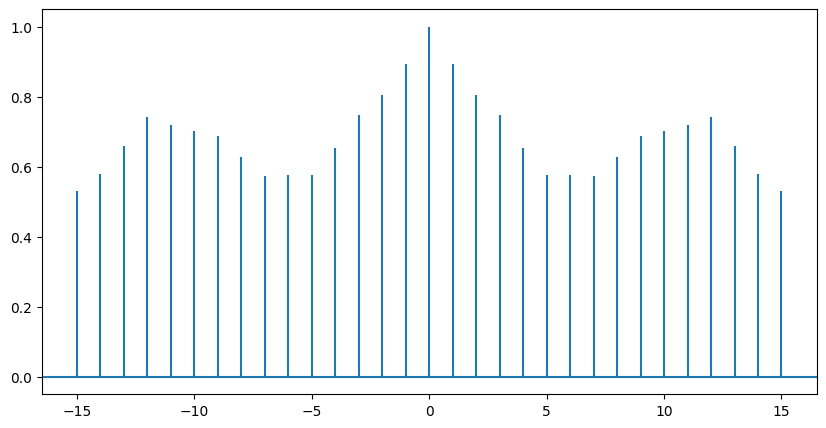

In [8]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def find_period(y: np.array, maxlags=10, top_n=1) -> int:
    acf_vals = acf(y, nlags=maxlags)
    return (np.argsort(-1 * acf_vals)[1:top_n+1])

aantalCalls = calls4jaar['AantalCalls']  # Data

fig, ax = plt.subplots(figsize=(10, 5))
lags, acfs, _, _ = ax.acorr(aantalCalls, maxlags=15)
autocorrelatie = pd.DataFrame({'lags': lags, 'acf': acfs}).sort_values(by='acf', ascending=False)
display(autocorrelatie)

periode = find_period(aantalCalls, maxlags=20, top_n=1)
print("Periode:", periode)

# periode = 12

b) Hoe groot is de autocorrelatie voor deze periode?

In [3]:
autocorrelatieGroot = autocorrelatie['acf'].iloc[8]

print("Autocorrelatie Groot", autocorrelatieGroot)

Autocorrelatie Groot 0.7413006737090464


c) Gaan we het additief of multiplicatief model gebruiken? Maak een grafiek van het aantal calls.

Multiplicativemodel


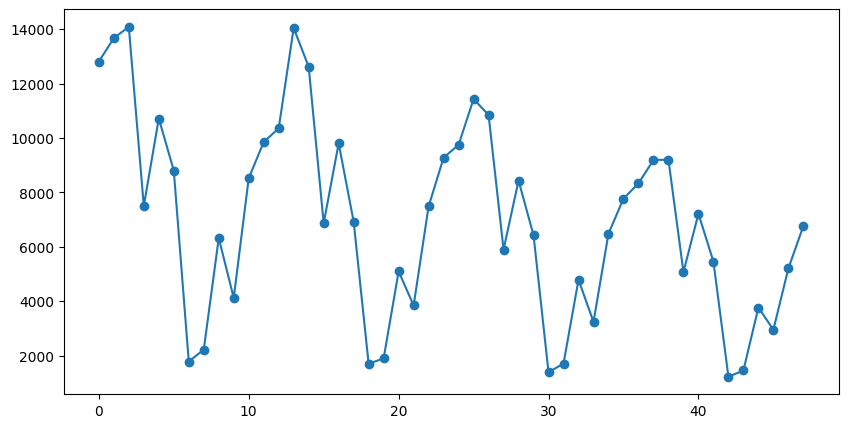

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

AantalCalls = calls4jaar['AantalCalls']
sd_model = seasonal_decompose(AantalCalls, model='multiplicative', period=12)
seasonal_std = np.std(sd_model.seasonal)
residual_std = np.std(sd_model.resid)
std_ratio = seasonal_std/residual_std

if std_ratio > 1:
	print("Multiplicativemodel")
else:
	print("Additivemodel")

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.plot(calls4jaar.AantalCalls, marker='o')

d) Als we de trend benaderen door een rechte, wat is de waarde van de slope (richtingscoëfficient)?

In [9]:
from W20P4.forecast import GeneralRegression
from statsmodels.tsa.seasonal import seasonal_decompose

aantalCalls = calls4jaar['AantalCalls']  # Data

sd_model = seasonal_decompose(aantalCalls, model='multiplicative', period=12)
data = sd_model.trend.dropna()

X = data.index.to_numpy()
y = data.to_numpy()

reg_model = GeneralRegression()
reg_model.fit(X, y)

print(reg_model.coef_)

# slope = -80.43607357
# De helling van de trend geeft de mate van stijging of daling van de tijdreeks aan in de loop van de tijd.
# In dit voorbeeld is de helling van de trend berekend als -80.44, wat aangeeft dat de tijdreeks afneemt met een snelheid van 80.44 eenheden per tijdseenheid.

[  0.         -80.43607357]


e) Geef de voorspelling voor de volgende 2 maand en maak ook een grafiek.

,48,49
linear_combination,8673.548823,12200.537176


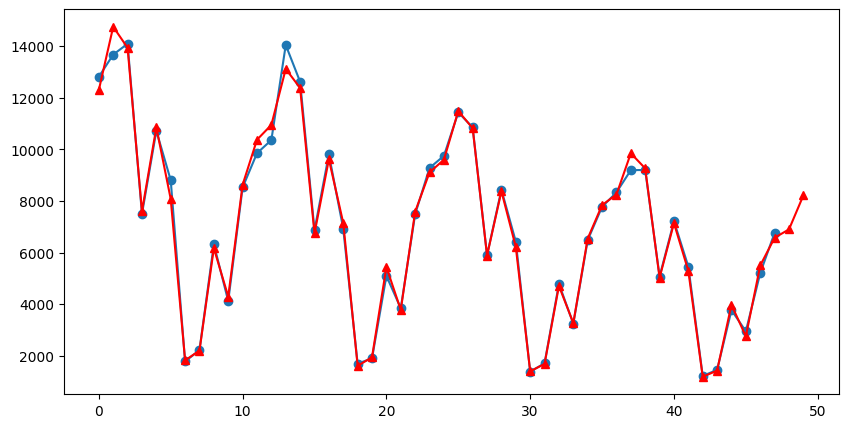

In [10]:
from W20P4.forecast import seasonal_decomposition_forecast, linear_combination, predict

prediction = seasonal_decomposition_forecast(reg_model, sd_model, 0, 50, method='m', m=12)
fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.plot(calls4jaar.AantalCalls, marker='o')
_ = ax.plot(prediction, marker='^', color='red')

PredictionData = pd.DataFrame(predict(calls4jaar.AantalCalls, 0, 50, linear_combination)[48:], columns=['linear_combination'], index=range(48, 50)).transpose()
display(PredictionData)

f) Geef de waarde van de MAPE voor het model.

In [11]:
MAPE = np.nanmean(np.abs(sd_model.resid / calls4jaar.AantalCalls))
MAE = np.nanmean(np.abs(sd_model.resid))
RMSE = np.sqrt(np.nanmean(np.square(sd_model.resid)))

metrics_df = pd.DataFrame({'Metric': ['MAPE', 'MAE', 'RMSE'], 'Value': [MAPE, MAE, RMSE]})
display(metrics_df)

,Metric,Value
0,MAPE,0.000216
1,MAE,0.999542
2,RMSE,0.999957
